4. Exercício que utiliza validação cruzada. Usando o arquivo covid19.csv , onde onde a primeira coluna são os valores de x (i.e., atributo) representando o número de dias
desde o primeiro caso confirmado de COVID-19 e a segunda coluna são os valores de y (i.e., objetivo ou rótulo), representando o número de casos de COVID-19 ativos. Leia o
conteúdo do arquivo, ou seja, os vetores x e y, com os seguintes comandos:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv(‘./covid19.csv', header=None)
x = df[0].to_numpy()
y = df[1].to_numpy()
x = x.reshape(len(x),1)
y = y.reshape(len(y),1)
fig = plt.figure(figsize=(10,10))
plt.plot(x, y, 'b.')
Em seguida, faça o seguinte
a. Plote os valores do arquivo, i.e., um gráfico mostrando o dias desde o primeiro caso versus o número de casos ativos.
b. Encontre uma aproximação polinomial que represente bem os dados do arquivo. Para encontrar a melhor aproximação, utilize os seguintes métodos: validação
cruzada holdout (com 80% do conjunto original para treinamento e 20% para validação), validação cruzada k-fold (com k=10 folds), validação cruzada leave-p-out (com p=1) e curvas de aprendizado. Analise polinômios com ordem variando de 1 até 12.
c. Em seguida, de posse da melhor ordem de polinômio que aproxima os dados do arquivo csv, treine o modelo com todos os dados do arquivo csv. Utilize padronização de atributos com a classe StandardScaler da biblioteca SciKit-Learn.
d. De posse do modelo treinado, crie um vetor x variando de 1 a 70 com incrementos de 1 em 1, i.e., número de dias desde o primeiro caso registrado até 70 dias depois, e faça a predição do número de casos ativos até 70 dias após o primeiro caso registrado.
e. Sabendo que o número total de leitos de UTI no Brasil é de 40600 (aqui vamos supor que nenhum leito está ocupado no momento), preveja em quantos dias desde o início do primeiro caso registrado no Brasil (26-02-2020) o número de leitos total seria atingido.

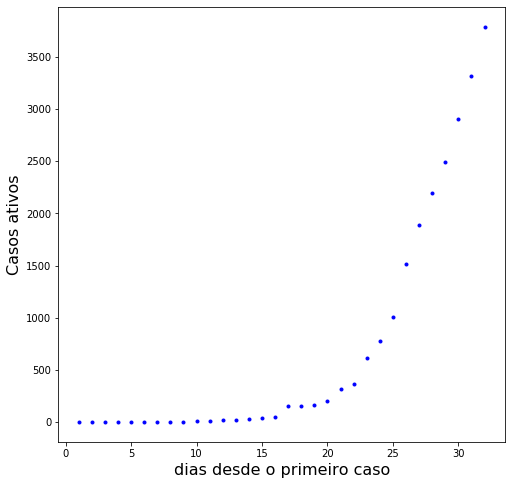

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
import json
import requests
import pandas as pd
import numpy as np
import tqdm
import warnings
import csv

df = pd.read_csv('D:\Mestrado\Joao-852-tp555\lista3\covid19.csv', header=None)

x = df[0].to_numpy()
y = df[1].to_numpy()

X =  x.reshape(len(y), 1)
y =  y.reshape(len(y), 1)

# Split training and validation set
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=25)

fig = plt.figure(figsize=(8,8))
plt.plot(x, y, 'b.')
plt.xlabel('dias desde o primeiro caso',  fontsize=16)
plt.ylabel('Casos ativos',  fontsize=16)
plt.show()

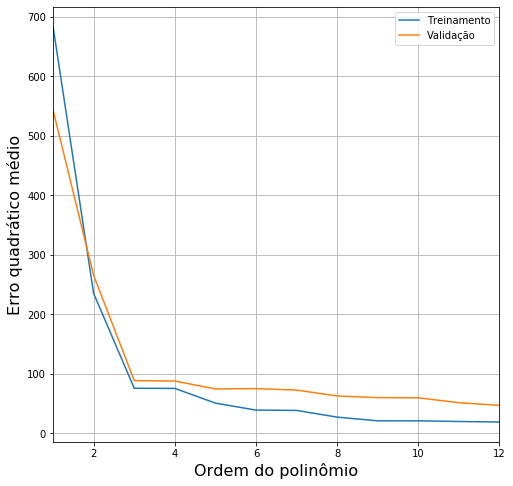

In [7]:
include_bias = False
error_train = []
error_val = []
mean_vec = []
std_vec = []

for d in range(1, 13):
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])
    
    # Perform polynomial regression.
    polynomial_regression.fit(x_train, y_train)
    
    y_train_predict = polynomial_regression.predict(x_train)
    
    y_val_predict = polynomial_regression.predict(x_val)    
    
    error_train.append(np.sqrt(mean_squared_error(y_train, y_train_predict)))

    error_val.append(np.sqrt(mean_squared_error(y_val, y_val_predict)))

# Plot
plt.figure(figsize=(8, 8))
plt.plot(range(1, 13), error_train, label='Treinamento')
plt.plot(range(1, 13), error_val, label='Validação')
plt.xlabel('Ordem do polinômio',  fontsize=16)
plt.ylabel('Erro quadrático médio',  fontsize=16)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

plt.show()

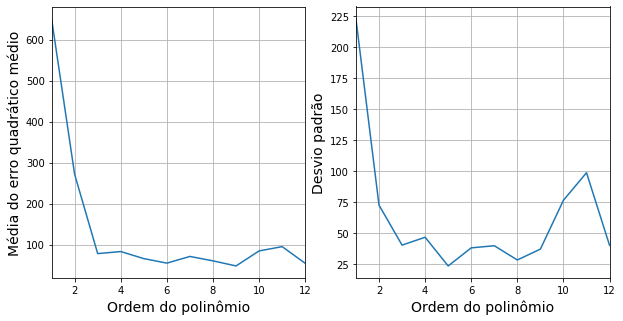

In [8]:
# Instantiate the k-Fold object.
kfold = KFold(n_splits=10, shuffle=True, random_state=32)

error_train = []
error_val = []
mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    lin_scores = cross_val_score(polynomial_regression, X, y, scoring='neg_mean_squared_error', cv=kfold)
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())

# Plot
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 13), mean_vec)
plt.xlabel('Ordem do polinômio',  fontsize=14)
plt.ylabel('Média do erro quadrático médio',  fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 13), std_vec)
plt.xlabel('Ordem do polinômio',  fontsize=14)
plt.ylabel('Desvio padrão',  fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()

plt.show()

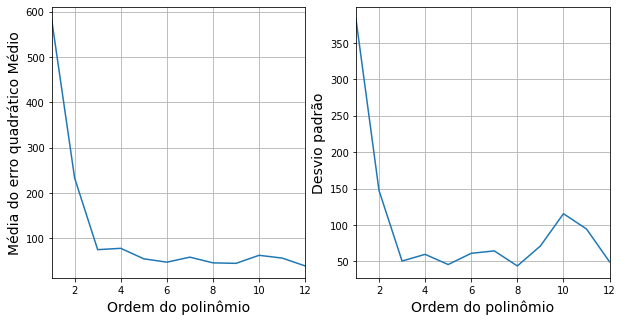

In [9]:
# Instantiate the LOOCV object.
loocv = LeaveOneOut()

mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    lin_scores = cross_val_score(polynomial_regression, X, y, scoring='neg_mean_squared_error', cv=loocv)
        
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())
    
# Plot
plt.figure(figsize=(10, 5))

# 1º figura
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 13), mean_vec)
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do erro quadrático Médio', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()

# 2º figura
ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 13), std_vec)
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()

plt.show()

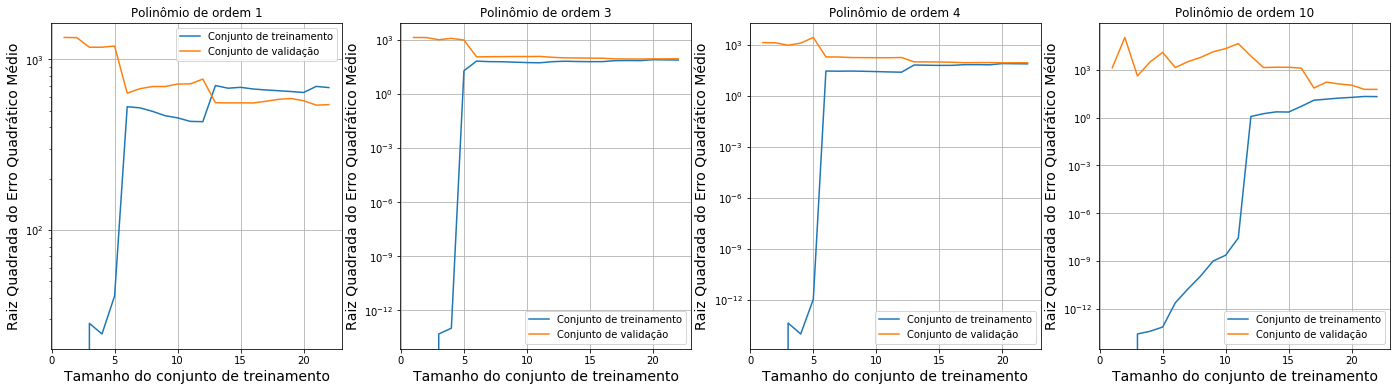

In [10]:
degrees = [1, 3, 4, 10]

plt.figure(figsize=(24, 6))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=degrees[i], include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    error_training = []
    error_validation = []
    error_test = []
    for m in range(1,len(x_train)+1):

        # Perform polynomial regression.
        polynomial_regression.fit(x_train[:m], y_train[:m])

        # Use the trained model for prediction of the training set.
        y_train_predict = polynomial_regression.predict(x_train[:m])

        # Use the trained model for prediction of the validation set.
        y_val_predict = polynomial_regression.predict(x_val)       

        # Calculate MSE for training set.
        error_training.append(mean_squared_error(y_train[:m], y_train_predict))

        # Calculate MSE for validation set.
        error_validation.append(mean_squared_error(y_val, y_val_predict))     

    plt.plot(range(1,len(x_train)+1), np.sqrt(error_training), label='Conjunto de treinamento')
    plt.plot(range(1,len(x_train)+1), np.sqrt(error_validation), label='Conjunto de validação')
    plt.yscale('log')
    plt.xlabel('Tamanho do conjunto de treinamento', fontsize=14)
    plt.ylabel('Raiz Quadrada do Erro Quadrático Médio', fontsize=14)
    plt.grid()
    plt.title('Polinômio de ordem '+str(degrees[i]))
    plt.legend(loc='best')

plt.show()

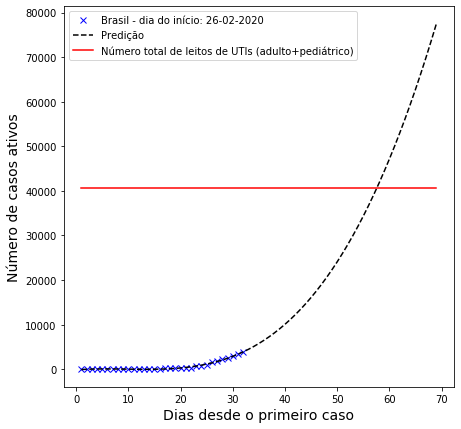

In [11]:
degree = 3
include_bias = False

# Instantiate a polynomial with the given degree.
poly_features = PolynomialFeatures(degree=degree, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
std_scaler = StandardScaler()
# Instantiate a linear regressor.
lin_reg = LinearRegression()

# Create a pipeline of actions.
model = Pipeline([
    ("poly_features", poly_features),
    ("std_scaler", std_scaler),
    ("lin_reg", lin_reg),
])

# Train model.
model.fit(X, y)

# Perform prediction for 70 days.
X_pred = np.arange(1, 70).reshape(-1, 1)
y_pred = model.predict(X_pred)
X_pred = X_pred.reshape(1, -1)[0]

plt.figure(figsize=(7, 7))
plt.plot(X,y,'bx',label='Brasil - dia do início: 26-02-2020')
plt.plot(X_pred,y_pred,'k--',label='Predição')
plt.plot(X_pred,40600*np.ones(len(X_pred)),'r',label='Número total de leitos de UTIs (adulto+pediátrico)')
plt.xlabel('Dias desde o primeiro caso', fontsize=14)
plt.ylabel('Número de casos ativos', fontsize=14)
plt.legend()

plt.show()

In [12]:
dia_ate_colapso_de_leitos = min([i+1 for i,v in enumerate(y_pred) if v >= 40600])
print('e. Número de dias até lotar os leitos: ', dia_ate_colapso_de_leitos)

e. Número de dias até lotar os leitos:  58
